### Spacee DS/DE Technical Assessment
This assessment will consist of two parts.  The first will require Python or R, while the second will require SQL.

Upon completion, please either attach relevant file(s) or send a link to your own GitHub repository replying to the email from which you have received this exercise.

You are encouraged to think of this as an incremental exercise (i.e., reply when you have implemented the basic acceptance criteria, then again if you make further improvements or implement one or more of the bonuses).

#### 1. Python: Perform the following with the attached “top50.csv” file:
- Load the dataset and perform EDA and determine if any cleanup (data conversions, name changes, scaling, imputation of missing values, etc.) is needed.
- Determine if any correlation exists between features.
- Visualize and examine the distribution of popularity scores and show if any outliers or skewing exists.
- Perform any transformations as needed and create a model to predict the popularity of a song, while avoiding overfitting and showing relevant scores.



In [ ]:
# common modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#just in case it's not installed when you run this(remove comment hash)
#!pip install seaborn -q
import seaborn as sns

In [ ]:
#loading and trail (please change path when you run from your directory)
path = '/work/Spacee interview/top50.csv' 
df = pd.read_csv(path)
df.head(2)

,Unnamed: 0,Track.Name,Artist.Name,Genre,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
0,1,Se�orita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79
1,2,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92


In [ ]:
# tracing steps from here
df_raw = df.copy()
#ranking? just give it a name
df_raw = df_raw.rename(columns={'Unnamed: 0':'num_order'})

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   num_order         50 non-null     int64 
 1   Track.Name        50 non-null     object
 2   Artist.Name       50 non-null     object
 3   Genre             50 non-null     object
 4   Beats.Per.Minute  50 non-null     int64 
 5   Energy            50 non-null     int64 
 6   Danceability      50 non-null     int64 
 7   Loudness..dB..    50 non-null     int64 
 8   Liveness          50 non-null     int64 
 9   Valence.          50 non-null     int64 
 10  Length.           50 non-null     int64 
 11  Acousticness..    50 non-null     int64 
 12  Speechiness.      50 non-null     int64 
 13  Popularity        50 non-null     int64 
dtypes: int64(11), object(3)
memory usage: 5.6+ KB


In [ ]:
# column names just to see
df_raw.columns

Index(['num_order', 'Track.Name', 'Artist.Name', 'Genre', 'Beats.Per.Minute',
       'Energy', 'Danceability', 'Loudness..dB..', 'Liveness', 'Valence.',
       'Length.', 'Acousticness..', 'Speechiness.', 'Popularity'],
      dtype='object')

In [ ]:
# let's make some of these nicer
df_raw = df_raw.rename(columns={
    'Loudness..dB..': 'Loudness',
    'Valence.': 'Valence',
    'Length.': 'Length',
    'Acousticness..': 'Acousticness',
    'Speechiness.':'Speechiness'
})

#check
df_raw.columns

Index(['num_order', 'Track.Name', 'Artist.Name', 'Genre', 'Beats.Per.Minute',
       'Energy', 'Danceability', 'Loudness', 'Liveness', 'Valence', 'Length',
       'Acousticness', 'Speechiness', 'Popularity'],
      dtype='object')

First impressions
- Nothing is empty, ok
- The second field (Track.Name) seems to have non US ASCII characters in there. Google says Shawn Mendes' song is called Señorita so that would change. 
- Also not sure about whether the ranges of the other measures make sense so also something to look into

Let's get into all 14 of it's!

In [ ]:
# Trackname
df_raw['Track.Name'].unique()

array(['Se�orita', 'China', 'boyfriend (with Social House)',
       'Beautiful People (feat. Khalid)', 'Goodbyes (Feat. Young Thug)',
       "I Don't Care (with Justin Bieber)", 'Ransom', 'How Do You Sleep?',
       'Old Town Road - Remix', 'bad guy', 'Callaita',
       'Loco Contigo (feat. J. Balvin & Tyga)', 'Someone You Loved',
       'Otro Trago - Remix', 'Money In The Grave (Drake ft. Rick Ross)',
       'No Guidance (feat. Drake)', 'LA CANCI�N',
       'Sunflower - Spider-Man: Into the Spider-Verse', 'Lalala',
       'Truth Hurts', 'Piece Of Your Heart', 'Panini',
       'No Me Conoce - Remix', 'Soltera - Remix',
       'bad guy (with Justin Bieber)', "If I Can't Have You",
       'Dance Monkey', "It's You", 'Con Calma', 'QUE PRETENDES',
       'Takeaway', '7 rings', '0.958333333',
       'The London (feat. J. Cole & Travis Scott)', 'Never Really Over',
       'Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy)',
       'Otro Trago', 'Antisocial (with Travis Scott)', 

Quite a few songs where a language with characters not present in the English language are not processed (small yikes). Let's change those. 
- It would help if I know who sang the song so this doesn't take forever to find the right characters.
- This appears to functionally just be a label feature so won't spend too much time finding the right accent character right now

In [ ]:
# isolate those songs first (long way, I'm sure there is a faster nicer way)
def find_out(x):
    bytes_num = [ord(i) for i in x] 
    present = [i in range(0,128) for i in bytes_num]
    # check if effects of standardizing English exist
    if False in present:
        return True
    else:
        return False

# moment of truth
non_ascii_songs = list(df_raw[df_raw['Track.Name'].apply(lambda x: find_out(x))]['Track.Name'])
non_ascii_songs

['Se�orita',
 'LA CANCI�N',
 "fuck, i'm lonely (with Anne-Marie) - from �13 Reasons Why: Season 3�",
 'Te Robar�']

In [ ]:
# replace (its the same one so replacing it manually)
# filters 
df_filter_n = df_raw['Track.Name']==non_ascii_songs[0]
df_filter_o = df_raw['Track.Name']==non_ascii_songs[1]
df_filter_empty = df_raw['Track.Name']==non_ascii_songs[2]
df_filter_e = df_raw['Track.Name']==non_ascii_songs[3]

# replace
df_raw.loc[df_filter_n,'Track.Name'] = df_raw['Track.Name'].apply(lambda x: x.replace('�','n'))
df_raw.loc[df_filter_o,'Track.Name'] = df_raw['Track.Name'].apply(lambda x: x.replace('�','O'))
df_raw.loc[df_filter_e,'Track.Name'] = df_raw['Track.Name'].apply(lambda x: x.replace('�','e'))
df_raw.loc[df_filter_empty,'Track.Name'] = df_raw['Track.Name'].apply(lambda x: x.replace('�',''))

# checking
df_raw['Track.Name'].unique()

array(['Senorita', 'China', 'boyfriend (with Social House)',
       'Beautiful People (feat. Khalid)', 'Goodbyes (Feat. Young Thug)',
       "I Don't Care (with Justin Bieber)", 'Ransom', 'How Do You Sleep?',
       'Old Town Road - Remix', 'bad guy', 'Callaita',
       'Loco Contigo (feat. J. Balvin & Tyga)', 'Someone You Loved',
       'Otro Trago - Remix', 'Money In The Grave (Drake ft. Rick Ross)',
       'No Guidance (feat. Drake)', 'LA CANCION',
       'Sunflower - Spider-Man: Into the Spider-Verse', 'Lalala',
       'Truth Hurts', 'Piece Of Your Heart', 'Panini',
       'No Me Conoce - Remix', 'Soltera - Remix',
       'bad guy (with Justin Bieber)', "If I Can't Have You",
       'Dance Monkey', "It's You", 'Con Calma', 'QUE PRETENDES',
       'Takeaway', '7 rings', '0.958333333',
       'The London (feat. J. Cole & Travis Scott)', 'Never Really Over',
       'Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy)',
       'Otro Trago', 'Antisocial (with Travis Scott)', 

In [ ]:
#OK now the artists, order so we can see all the lil's
set(df_raw['Artist.Name'].unique())

{'Ali Gatie',
 'Anuel AA',
 'Ariana Grande',
 'Bad Bunny',
 'Billie Eilish',
 'Chris Brown',
 'DJ Snake',
 'Daddy Yankee',
 'Drake',
 'Ed Sheeran',
 'J Balvin',
 'Jhay Cortez',
 'Jonas Brothers',
 'Katy Perry',
 'Khalid',
 'Kygo',
 'Lady Gaga',
 'Lauv',
 'Lewis Capaldi',
 'Lil Nas X',
 'Lil Tecca',
 'Lizzo',
 'Lunay',
 'MEDUZA',
 'Maluma',
 'Marshmello',
 'Martin Garrix',
 'Nicky Jam',
 'Post Malone',
 'ROSAL�A',
 'Sam Smith',
 'Sech',
 'Shawn Mendes',
 'Taylor Swift',
 'The Chainsmokers',
 'Tones and I',
 'Y2K',
 'Young Thug'}

only Rosalia this time with the accent stuff that English doesn't have.

In [ ]:
# replace
df_filter_ros = df_raw['Artist.Name']=='ROSAL�A'
df_raw.loc[df_filter_ros,'Artist.Name'] = df_raw['Artist.Name'].apply(lambda x: x.replace('�','I'))

# check
df_raw['Artist.Name'].unique()

array(['Shawn Mendes', 'Anuel AA', 'Ariana Grande', 'Ed Sheeran',
       'Post Malone', 'Lil Tecca', 'Sam Smith', 'Lil Nas X',
       'Billie Eilish', 'Bad Bunny', 'DJ Snake', 'Lewis Capaldi', 'Sech',
       'Drake', 'Chris Brown', 'J Balvin', 'Y2K', 'Lizzo', 'MEDUZA',
       'Jhay Cortez', 'Lunay', 'Tones and I', 'Ali Gatie', 'Daddy Yankee',
       'The Chainsmokers', 'Maluma', 'Young Thug', 'Katy Perry',
       'Martin Garrix', 'Jonas Brothers', 'Lauv', 'Kygo', 'Taylor Swift',
       'Lady Gaga', 'Khalid', 'ROSALIA', 'Marshmello', 'Nicky Jam'],
      dtype=object)

In [ ]:
# ok lastly in text values, the genre
set(df_raw.Genre.unique())

{'atl hip hop',
 'australian pop',
 'big room',
 'boy band',
 'brostep',
 'canadian hip hop',
 'canadian pop',
 'country rap',
 'dance pop',
 'dfw rap',
 'edm',
 'electropop',
 'escape room',
 'latin',
 'panamanian pop',
 'pop',
 'pop house',
 'r&b en espanol',
 'reggaeton',
 'reggaeton flow',
 'trap music'}

Ok, so that's a lot of pop categories. Might have to come back to later but I don't know yet (seeing as how we are going to look into popularity.. we'll see)


#### Time to look at Numbers (or numerical representations)
Everything else is represented numerically whether it's continuous or not, we're about to find out. Table time

In [ ]:
# describe
df_raw.describe()

,num_order,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
count,50.00000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,120.060000,64.060000,71.38000,-5.660000,14.660000,54.600000,200.960000,22.160000,12.480000,87.500000
std,14.57738,30.898392,14.231913,11.92988,2.056448,11.118306,22.336024,39.143879,18.995553,11.161596,4.491489
min,1.00000,85.000000,32.000000,29.00000,-11.000000,5.000000,10.000000,115.000000,1.000000,3.000000,70.000000
25%,13.25000,96.000000,55.250000,67.00000,-6.750000,8.000000,38.250000,176.750000,8.250000,5.000000,86.000000
50%,25.50000,104.500000,66.500000,73.50000,-6.000000,11.000000,55.500000,198.000000,15.000000,7.000000,88.000000
75%,37.75000,137.500000,74.750000,79.75000,-4.000000,15.750000,69.500000,217.500000,33.750000,15.000000,90.750000
max,50.00000,190.000000,88.000000,90.00000,-2.000000,58.000000,95.000000,309.000000,75.000000,46.000000,95.000000


#### Some quick observations
- An 88 in energy or danceability means something very different than an 88 for beats per minute
- All the loudness (at least in this dataset) is measured with negative values. Considering other variables, may be a good candidate to standardize
- Except for loudness and popularity, the deviation is relatively high for these other features with length, valence, and beats per minute being very up there.

#### Correlations
Let's see if there are any implied relationships and what that means for changing any of the features because of how it would influence interpretation.

<Figure size 1152x576 with 0 Axes>

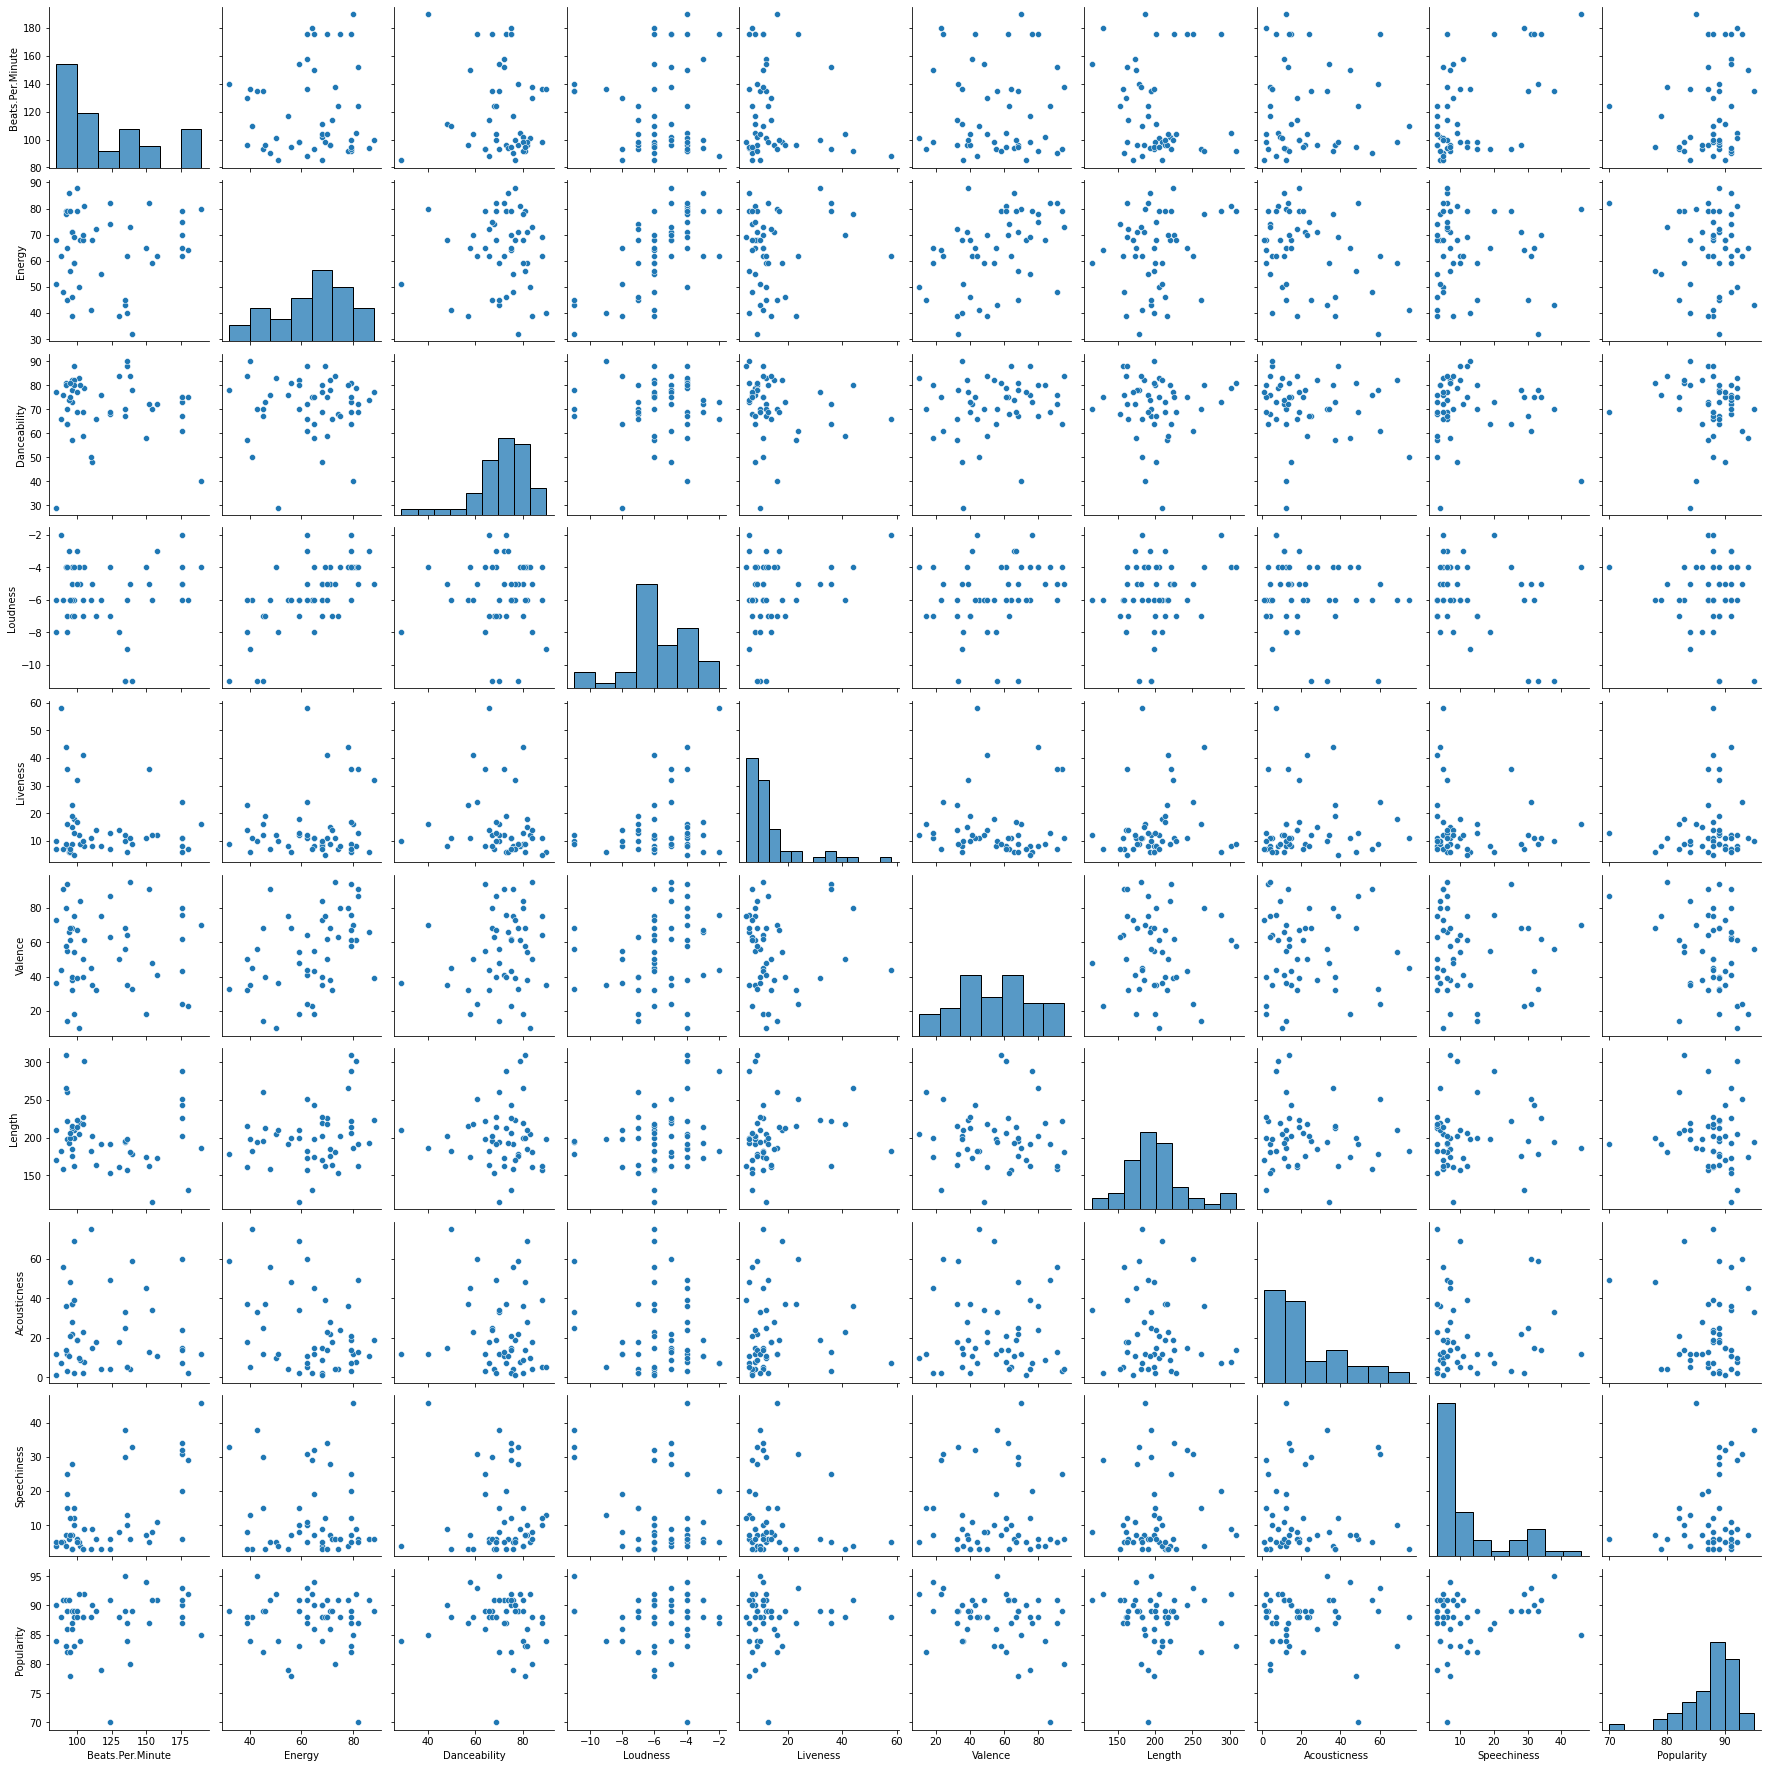

In [ ]:
%matplotlib inline
sns.pairplot(df_raw[df_raw.columns[1:]])
plt.show()

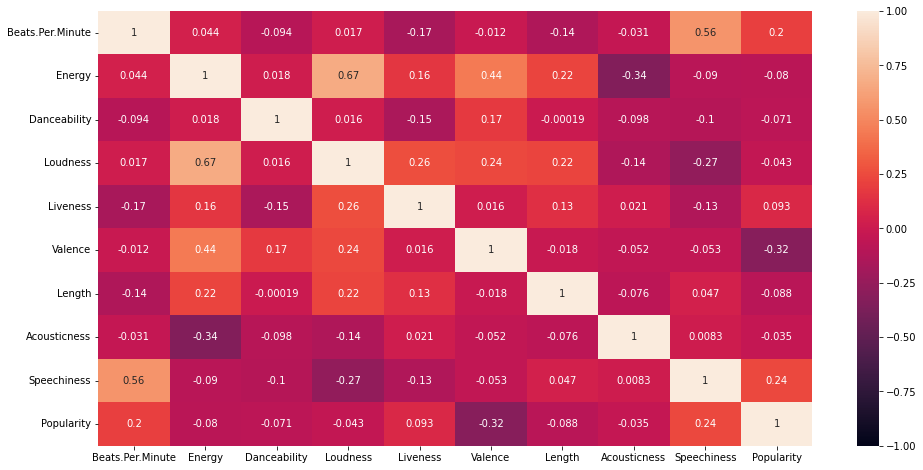

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(df_raw[df_raw.columns[1:]].corr(), vmin=-1, vmax=1, annot=True)
plt.show()

#### More observations
- Almost everyone here is skewed (beats per minute, loudness, liveness, acousticness, speechiness are right skewed; dancebility, energy, valence are left skewed)
- Not any relatively strong correlations between popularity and other variables. The most noticeable one is that lower valence tends to coincide with more popular songs. And there is some positive correlation between popularity and beats per minute as well as speechiness. Makes sense people like upbeat things in life, not sure about the speechiness yet :shrug:.
- Energy has some eye-catching positive correlations with loudness (makes common sense) and valence. Lower accousticness tends to occur with songs of higher energy.
- Speechiness and beats per minute also have a healthy positive correlation

#### More on Popularity


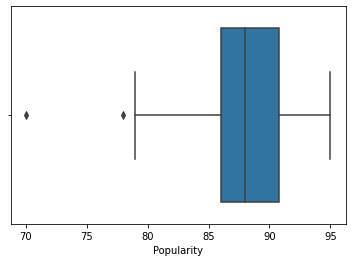

In [ ]:
#What's this distribution look like? Any outliers?
sns.boxplot(x=df_raw['Popularity'])
plt.show()

Ah, so yes there are two outliers (in this dataset). They are both of the least popular kind. Let's see what these are and how they affect the correlations when ignored (I know living dangerously for two seconds). But also just the one with 70 because the second outlier is closer to everyone else.

In [ ]:
df_raw.loc[df_raw['Popularity']<79,]

,num_order,Track.Name,Artist.Name,Genre,Beats.Per.Minute,Energy,Danceability,Loudness,Liveness,Valence,Length,Acousticness,Speechiness,Popularity
25,26,If I Can't Have You,Shawn Mendes,canadian pop,124,82,69,-4,13,87,191,49,6,70
39,40,"fuck, i'm lonely (with Anne-Marie) - from �13 ...",Lauv,dance pop,95,56,81,-6,6,68,199,48,7,78


Awww ok. But also dance pop is not popular????? OK. Don't know these ones but let's see if it changes the descriptive stats in the way we would think based on previous observations

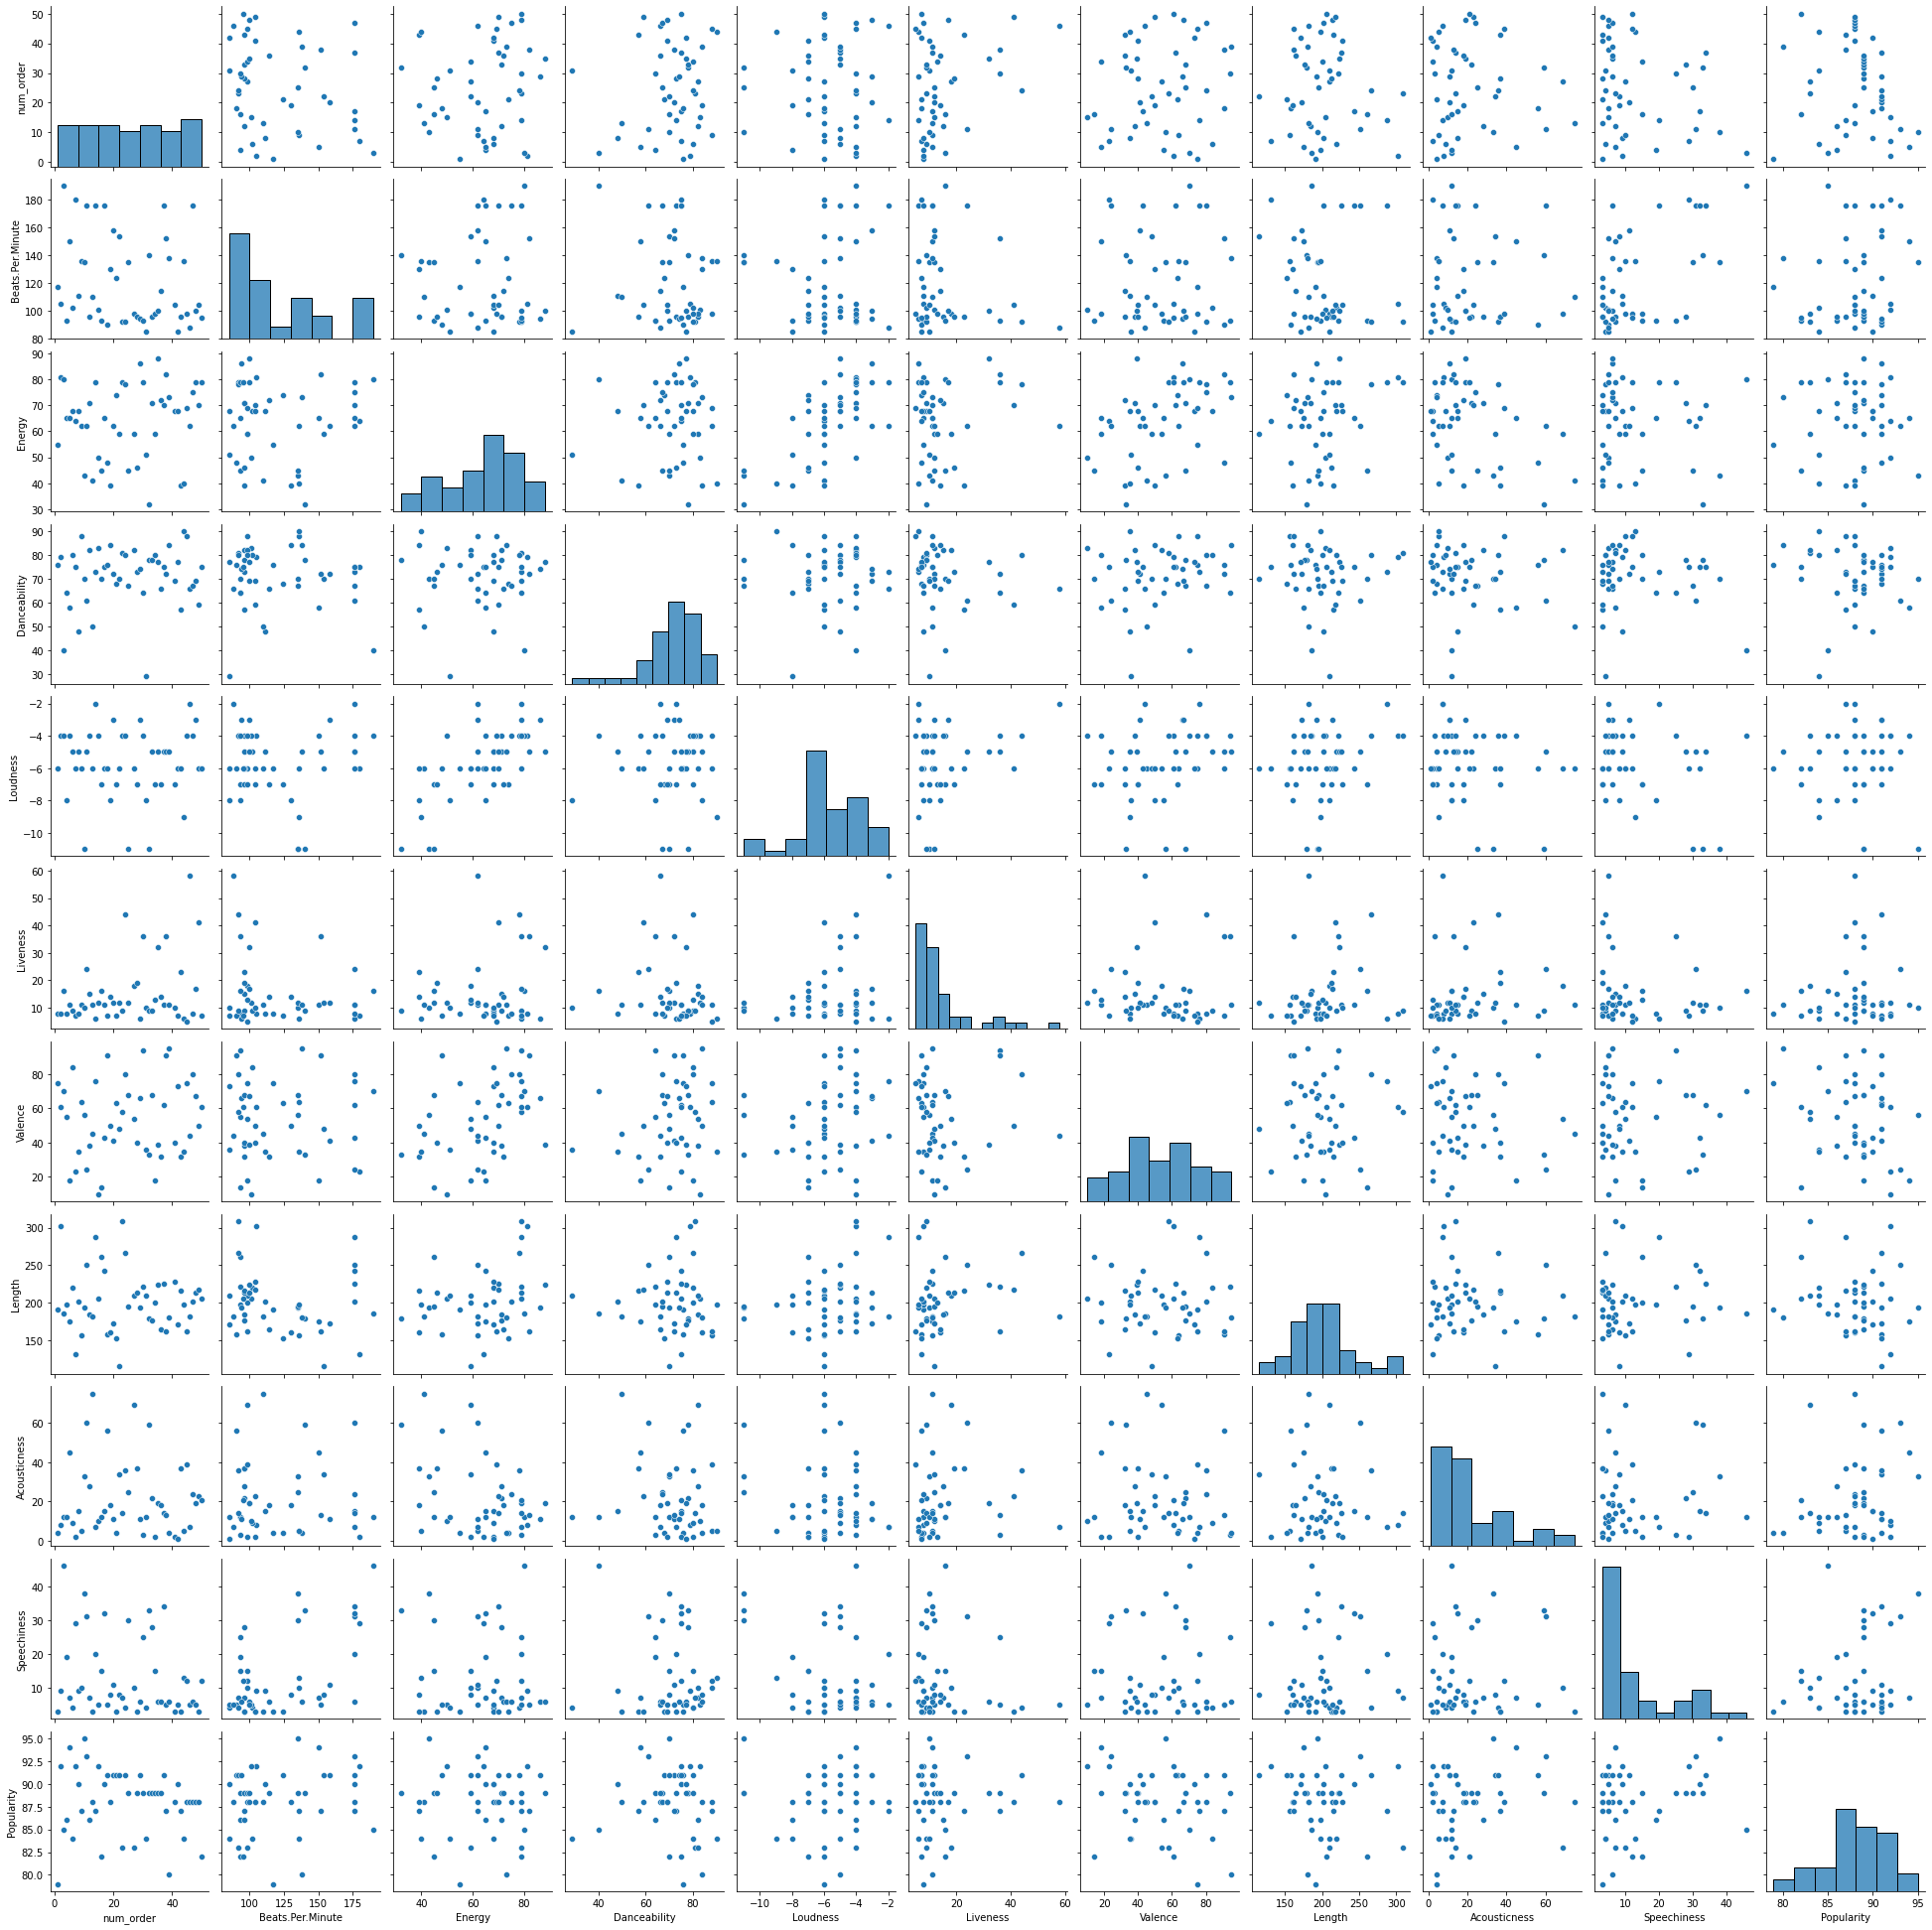

In [ ]:
sns.pairplot(df_raw.loc[df_raw['Popularity']>78,])
plt.show()

OK, so after reviewing those variables together, here is what we learned
- There wasn't tooo much change with ignoring outliers. Either way, we only have 50 observations so ignoring things is a luxury.
- Going to leave popularity as a continuous variable and not bin it to infer what popular means (we'll stick to less popular and more popular vs less likely or more likely to be popular so a regression works)
- The variables identified earlier as having *some* form of a relationship with popularity will be used as regressors i.e. speechiness, beats per minute(highly correlated with speechiness so leaving her out), and valence. Here is a reminder
- Might help interpreting popularity on a log scale because these variables are not all on the same weight/scale but let's see first (come to this later)

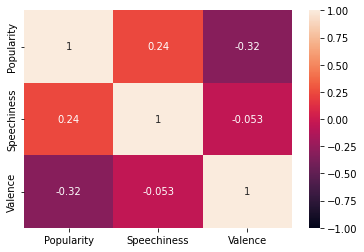

In [ ]:
sns.heatmap(df_raw[['Popularity','Speechiness','Valence']].corr(), vmax=1, vmin=-1,annot=True)
plt.show()

In [ ]:
# Modeling Popularity
# too small a dataset to do a train and test split on :(
# modules
from sklearn.linear_model import LinearRegression
#!pip install statsmodels -q
import statsmodels.api as sm

# variables
X = df_raw[['Speechiness','Valence']]
X = sm.add_constant(X)
y = df_raw['Popularity']

# do the thing
model = sm.OLS(y,X)
results = model.fit()
y_pred = results.predict()

#### How did this do?
- Checking what the predicted vs. actual values look like
- What are the model measures looking like?
- We don't want to overfit so we're hoping to achieve low variability between our actual and predicted y's in this fun bias/variance trade-off

In [ ]:
# Model scores
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Popularity   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     4.154
Date:                Mon, 14 Feb 2022   Prob (F-statistic):             0.0218
Time:                        19:37:55   Log-Likelihood:                -141.48
No. Observations:                  50   AIC:                             289.0
Df Residuals:                      47   BIC:                             294.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          89.7426      1.763     50.914      0.000      86.197      93.289
Speechiness     0.0894      0.054      1.651      0.105      -0.020       0.198
Valence        -0.0615      0.027     -2.272      0.028      -0.116      -0.007
==============================================================================
Omnibus:                       15.770   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.185
Skew:                          -1.160   Prob(JB):                     6.83e-05
Kurtosis:                       4.957   Cond. No.                         177.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

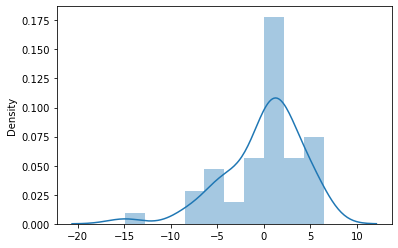

In [ ]:
sns.distplot(results.resid)

In [ ]:
# RMSE moment of truth for checking variance
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y, y_pred, squared=False)
print("Mean (non) squared error around the y values is {}".format(rms))

Mean (non) squared error around the y values is 4.098778345324393


#### Results Observations
- Residuals are not properly distributed so our variance is definitely off a.k.a highly likely we are overfitting
- This is not a model that captures a lot of the information that influences popularity of a song i.e. the low R-square is saying a lot of the variance to change popularity is not accounted for with our regressors
- Of all the regressors we chose (assuming an alpha of 0.05), only the decrease in valence (a small one at that), positively adds to a song's popularity. Google told me that valence has to do with the grammatical elements of a word that combine to form a sentence. It looks like a lot of us don't care about long sentences as much when it comes to piquing interest in a way that influences popularity
- The information criteria metrics are also sad looking here, we're not learning a lot about popularity based on this sample.
- The residual difference (RMSE) is not good, not very robust to outliers like we have so this is not helpful to the mission of not overfitting. **This model is likely overfitted** because of the sample size and the outliers.

#### Your Own Model:
2. Write the code to calculate and plot the Precision-Recall curve for any existing ML model you like.  Could be a predictor, classifier, or detector.  Use any simple ground truth dataset you like.  For example, if you use an object classifier or detector, it could be of dogs and cats, or bicycles and cars, or anything like that.  However, the dataset choice is yours.  Turn in the code sample, GT dataset, and PR curve plot.
*Bonus for adding the P-R results of any second corresponding predictor, classifier, or detector to the same chart for comparison.

#### Dataset: Marijuana Consumption
In the early to mid 2010s, marijuana allowance laws started getting passed. This dataset was used (when I was a student, created it) to see if laws had an effect on consumption and price. If I'm understanding correctly, the model can already exist and you want to see the curve. With that assumption in mind, here goes.

In [ ]:
#load regression libraries/modules needed
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier

## For k- mean Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
marijuana = pd.read_csv('marijuana_dataset.csv')
marijuana = marijuana[marijuana['state'] != 'California']
marijuana.head()

,state,state_code,dayspostlegal,distance,income,legal,month,ppg,quality_score,quantity,year
0,Colorado,8,253,2343.9370,48869,1,7,8.113011,3,28.349524,2013
1,Colorado,8,201,1947.1980,48869,1,5,7.054792,2,28.349524,2013
2,Colorado,8,193,2343.9370,48869,1,5,7.054792,3,28.349524,2013
3,Colorado,8,297,2358.2251,48869,1,8,8.465751,2,14.174762,2013
4,Colorado,8,200,2230.3601,48869,1,5,8.818490,2,28.349524,2013


Ran out of time switching back and forth to refactor, sorry! I have attached my original notebook from the work I did then and added some of the things requested here. Apologies for making you read multiple things.

## SQL Portion:

In [ ]:
# Given the below table/database environment
"""
CREATE TABLE users
id INTEGER PRIMARY KEY,
firstName VARCHAR(30) NOT NULL,
lastName VARCHAR(30) NOT NULL;

CREATE TABLE sessions
id INTEGER PRIMARY KEY,
userId INTEGER NOT NULL FOREIGN KEY REFERENCES users(id),
duration DECIMAL NOT NULL;

CREATE TABLE transactions
id INTEGER PRIMARY KEY,
userId INTEGER NOT NULL FOREIGN KEY REFERENCES users(id)
productId INTEGER,
originDate TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
description VARCHAR(30),
qty DECIMAL;
"""


User data and their app usage data are kept in the tables above. Each user can have multiple sessions. Write a SQL query that:
- selects the ‘userIds’ with the top 50 average session durations
- selects their full name from the user table as a single new column
*Bonus for adding in a new column for each user and flagging their 3rd longest duration with 1,otherwise put 0 (put 0 if they have fewer than 3 sessions)


In [ ]:
# selects the ‘userIds’ with the top 50 average session durations
"""
WITH avg_durations AS (
    SELECT userID, AVG(duration) AS avg_duration
    FROM sessions
    GROUP BY 1
    ORDER BY 2 DESC
)
SELECT firstName || " " || lastName AS full_name 
FROM avg_durations av
LEFT JOIN users u ON u.userID = av.userID
LIMIT 50;
"""

In [ ]:
# the above plus selects the additional column to show third longest session
"""
WITH avg_durations AS (
    SELECT s.userID
    , u.firstName || " " || u.lastName AS full_name
    , AVG(duration) AS avg_duration
    FROM sessions s
    LEFT JOIN user u ON u.userID = s.userID
    GROUP BY 1,2
    ORDER BY 3 DESC
    LIMIT 50
),
long_sessions AS (
    SELECT userID
    , duration
    , ROW_NUMBER() OVER(PARTITION BY userID ORDER BY duration DESC) AS rn
    FROM sessions
    GROUP BY 1
    HAVING rn = 3
)
SELECT full_name
, CASE WHEN ls.userID IS NULL THEN 0 ELSE duration END AS third_longest_duration
FROM avg_durations av
LEFT JOIN long_sessions ls ON ls.userID = av.userID
"""

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=81b136ac-6d16-4fba-84b8-02f07bcf9435' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>